In [1]:
import os
import sys
sys.path.append(os.getcwd())
sys.path.append('/home/sydong/work/deepchem/cvxcharge/hogwild')

In [2]:
from hogwild.get_model import load_pretrained_model
from hogwild.get_data import load_data
model=load_pretrained_model()

from schnetpack.data.atoms import AtomsConverter
from ase.build import molecule
# from sklearn.linear_model import LinearRegression

import torch
# import pdb
# pdb.set_trace()
water=molecule("H2O")
converter=AtomsConverter(device="cpu")
inp=converter(water)
train,val,test=load_data('.')
max_mae=0
model.eval()

(32, 1)
(32, 1)
(32, 1)
model at /home/sydong/work/deepchem/cvxcharge/hogwild/final_cpu_model.pt
root path is /home/sydong/work/deepchem/cvxcharge
Data prepare finished
training batch number 20609
training point 659474
validation batch number 2912
validation point 93180


Sequential(
  (0): AtomisticModel(
    (representation): SchNet(
      (embedding): Embedding(100, 128, padding_idx=0)
      (distances): AtomDistances()
      (distance_expansion): GaussianSmearing()
      (interactions): ModuleList(
        (0): SchNetInteraction(
          (filter_network): Sequential(
            (0): Dense(in_features=50, out_features=128, bias=True)
            (1): Dense(in_features=128, out_features=128, bias=True)
          )
          (cutoff_network): CosineCutoff()
          (cfconv): CFConv(
            (in2f): Dense(in_features=128, out_features=128, bias=False)
            (f2out): Dense(in_features=128, out_features=128, bias=True)
            (filter_network): Sequential(
              (0): Dense(in_features=50, out_features=128, bias=True)
              (1): Dense(in_features=128, out_features=128, bias=True)
            )
            (cutoff_network): CosineCutoff()
            (agg): Aggregate()
          )
          (dense): Dense(in_features=128, 

In [3]:
total_error=[]
with torch.no_grad():
    for i,batch in enumerate(test):
        single_inp={k:v.to("cpu") for k,v in batch.items()}
        single_out=model(single_inp)
        error=single_inp['monopoles']-single_out
        total_error.extend(error)
        mae=torch.sum(error)/torch.count_nonzero(error)
        if mae > max_mae:
            max_mae=mae

In [5]:
import numpy as np

In [7]:
all_pos_model=torch.load("./all_pos_model/all_pos_cpu")

In [9]:
pos_error=[]
with torch.no_grad():
    for i,batch in enumerate(test):
        single_inp={k:v.to("cpu") for k,v in batch.items()}
        single_out=all_pos_model(single_inp)
        error=single_inp['monopoles']-single_out
        pos_error.extend(error)
        mae=torch.sum(error)/torch.count_nonzero(error)
        if mae > max_mae:
            max_mae=mae

In [15]:
import numpy as np
import matplotlib.pyplot as plt

In [6]:
errors=np.concatenate(total_error).squeeze()
np.sum(np.abs(errors))/np.count_nonzero(errors)

0.002516342163785593

0.002516342163785593

In [13]:
errors=np.concatenate(pos_error).squeeze()
np.sum(np.abs(errors))/np.count_nonzero(errors)

0.04823673896795848

Text(0, 0.5, 'error au.')

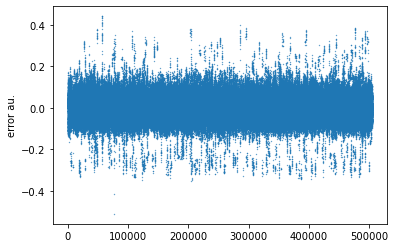

In [16]:
plt.scatter(range(len(errors)),errors,s=0.1)
plt.ylabel("error au.")
#fig=plt.gcf()
#fig.savefig("/home/sydong/work/workreport/July2/images/mae.png")

In [4]:
import numpy as np

In [5]:
x=np.concatenate(total_abs_error)

In [7]:
np.mean(x)

0.002174016

In [17]:
x=np.concatenate(total_error).squeeze()

ValueError: need at least one array to concatenate

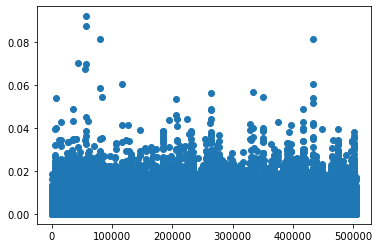

In [15]:
from matplotlib import pyplot as plt
error=x.squeeze()
plt.scatter(range(len(error)),error)

# Predict md trajectory

In [7]:
qm_result=[]
for i in range(8):
    charge=np.load("aspirin_charge_{}.npy".format(i))
    qm_result.append(charge)
total=np.concatenate(qm_result)

In [37]:
!pwd

/home/sydong/work/deepchem/cvxcharge


In [8]:
from schnetpack.datasets import MD17
from schnetpack.data import AtomsLoader
aspirin=MD17("~/data/apririn_md.db",molecule="aspirin",download=False)

In [9]:
results=[]
loader=AtomsLoader(aspirin,batch_size=64,shuffle=False)

In [10]:
with torch.no_grad():
    for i ,batch in enumerate(loader):
        out=model(batch)
        results.extend(out)
        if i>15:
            break

In [11]:
from matplotlib import pyplot as plt

In [21]:
atom_num=batch['_atomic_numbers']
atom_pos=batch['_positions']
import ase
from ase import atoms
aspirin=atoms.Atoms(positions=atom_pos[0],numbers=atom_num[0])

In [27]:
from ase.visualize import view
view(aspirin)

<Popen: returncode: None args: ['/home/sydong/program/anaconda3/envs/cvx/bin...>

In [12]:
another=np.load("mutipole_net.npy")

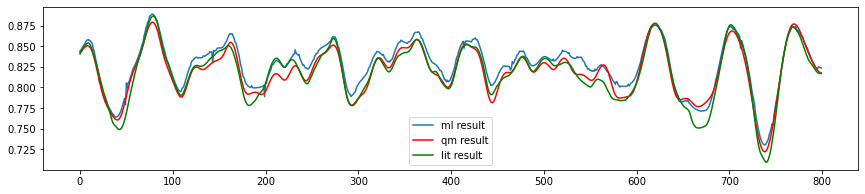

In [16]:
ax=plt.gca()
fig=plt.gcf()
fig.set_size_inches((30,3))
plt.plot(range(800),[results[i][11] for i in range(800)],label="ml result")
plt.plot(range(800),total[:,11],color="r",label="qm result")
plt.plot(range(800),another[:,11],color="g",label="lit result")
ratio = 0.2
x_left, x_right = ax.get_xlim()
y_low, y_high = ax.get_ylim()
ax.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)
plt.legend()
fig.savefig("./compare.png")

In [63]:
np.array([results[i].numpy()[7] for i in range(800)]).squeeze()

(800,)

In [82]:
for j  in range(20):
    a=np.mean(np.square((another[:,j].squeeze()-total[:,j].squeeze())))
    b=np.mean(np.square((np.array([results[j].numpy()[8] for i in range(800)]).squeeze()-total[:,j].squeeze())))
    print(b-a)

0.26478607577467883
0.08393539255332809
0.14211489228380525
0.2563359152937548
0.014846069198815585
0.08110866296646517
0.8864368228492673
0.000636920012482904
0.0008502403401053878
0.008949744385287606
1.748635088175245
1.8686471889955367
0.020986483829858328
1.0146704608779624
0.4985921070015659
0.5154459673500237
0.4808370774557638
0.46048114975143095
0.5548778252363704
0.5457130220723566


In [75]:
a-b

0.0002662017925527437

In [37]:
fig.savefig("/home/sydong/work/workreport/July2/images/conformation.png")

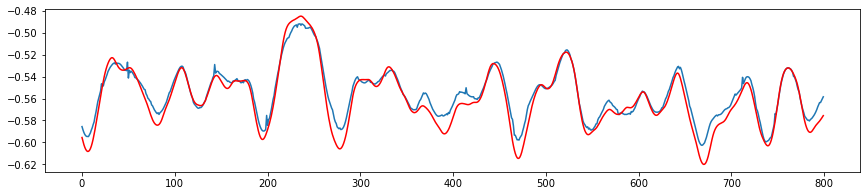

In [34]:
ax=plt.gca()
fig=plt.gcf()
fig.set_size_inches((30,3))
plt.plot(range(800),[results[i][7] for i in range(800)],)
plt.plot(range(800),total[:,7],color="r")
ratio = 0.2
x_left, x_right = ax.get_xlim()
y_low, y_high = ax.get_ylim()
ax.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)

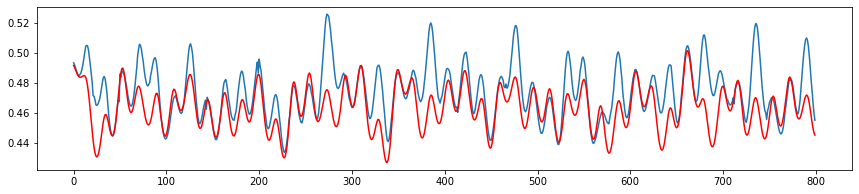

In [36]:
ax=plt.gca()
fig=plt.gcf()
fig.set_size_inches((30,3))
plt.plot(range(800),[results[i][13] for i in range(800)],)
plt.plot(range(800),total[:,13],color="r")
ratio = 0.2
x_left, x_right = ax.get_xlim()
y_low, y_high = ax.get_ylim()
ax.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)

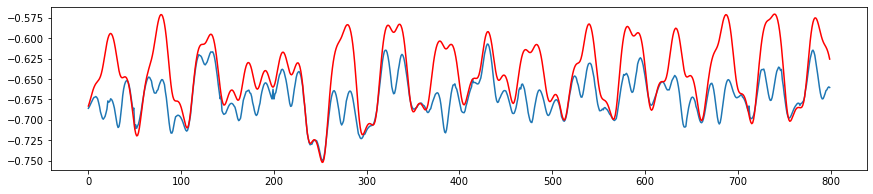

In [98]:
ax=plt.gca()
fig=plt.gcf()
fig.set_size_inches((30,3))
plt.plot(range(800),[results[i][9] for i in range(800)],)
plt.plot(range(800),total[:,9],color="r")
ratio = 0.2
x_left, x_right = ax.get_xlim()
y_low, y_high = ax.get_ylim()
ax.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)

In [ ]:
view()

In [54]:
coord=aspirin[0][ '_positions']
elem=aspirin[0]['_atomic_numbers']

In [55]:
import ase

In [101]:
from ase.io import read

In [105]:
dimer=read("/home/sydong/work/deepchem/cvxcharge/dimer/dimer_3_4.xyz")

In [106]:
view(dimer)

<Popen: returncode: None args: ['/home/sydong/program/anaconda3/envs/cvx/bin...>

In [60]:
from ase.visualize import view
view(mol)

<Popen: returncode: None args: ['/home/sydong/program/anaconda3/envs/cvx/bin...>

In [108]:
import pandas as pd

In [135]:
x=pd.read_csv("./dimer/dimer.csv",skip_blank_lines=True)

In [196]:
with open("./dimer/dimer.csv")as fhand:
    lines=fhand.readlines()
    content=[]
    total={}
    for Line in lines:
        line = Line.strip().split(",")
        if "FaONFaON" in line[0]:
            content.append("\n")
#             print(line[0].split()[0])
            content=["12\n\n"]
            total[line[0].split()[0]]=content
        elif line==[""]:
            pass
        elif len(line)==4:
            content.extend(Line.replace(",","    ").replace('−','-'))

In [197]:
for key,val in total.items():
    with open("./dimer/"+key+'.xyz',"w") as fhand:
        fhand.write("".join(val).strip(","))

In [200]:
for key in total:
    atom=read("./dimer/"+key+'.xyz')
    view(atom)

# Predict diemer

In [426]:
from hogwild.interface import ChargeNet

In [427]:
net=ChargeNet()

model at /home/sydong/work/deepchem/cvxcharge/hogwild/final_cpu_model.pt


In [235]:
dists=[key.split("-")[-1] for key in total.keys()]
dists.sort()
dists.append(dists.pop(0))

In [238]:
netresult=[]
qmresult=[]
for dist in dists:
    xyzfile="./dimer/"+"FaONFaON-"+dist+".xyz"
    atom=read(xyzfile)
    charge=net.calc(atoms=atom,total_charge=0)
    netresult.append(charge)
    npyfile="./dimer/"+"FaONFaON-"+dist+"..npy"
    qmresult.append(np.load(npyfile))

In [248]:
x=np.array(netresult).squeeze()
y=np.array(qmresult).squeeze()

In [292]:
symbol=atom.get_chemical_symbols()

In [264]:
mae=np.abs(x-y).mean(axis=1)

In [263]:
X=[float(dist) for dist in dists]

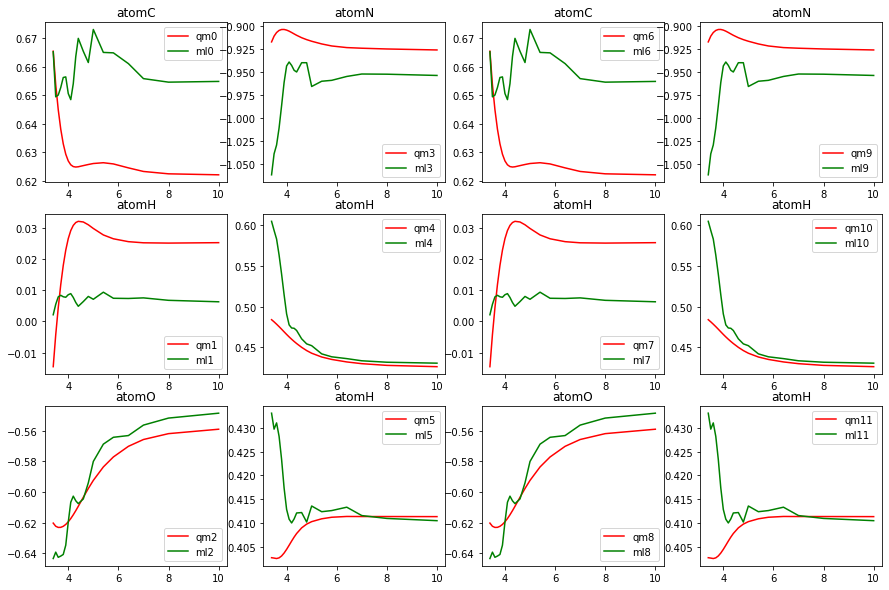

In [301]:
fig,ax=plt.subplots(3,4, figsize=(15,10))
for i in range(12):
    ax[i%3][i//3].plot(X,y[:,i],'r',label='qm{}'.format(i))
    ax[i%3][i//3].plot(X,x[:,i],'g',label='ml{}'.format(i))
    ax[i%3][i//3].set_title("atom{}".format(symbol[i]))
    ax[i%3][i//3].legend()

In [304]:
view(atom)

<Popen: returncode: None args: ['/home/sydong/program/anaconda3/envs/cvx/bin...>

# calculate with cid

In [21]:
!ls

'~'		        aspirin_charge_3.npy   cluster	     hogwild
 all_pos_model	        aspirin_charge_4.npy   data	     mutipole_net.npy
 aspirin_charge_0.npy   aspirin_charge_5.npy   dataprocess   testmae.ipynb
 aspirin_charge_1.npy   aspirin_charge_6.npy   dimer	     Untitled.ipynb
 aspirin_charge_2.npy   aspirin_charge_7.npy   eval.py


In [52]:
from hogwild.interface import ChargeNet 
from all_pos_model import interface

In [53]:
import importlib
importlib.reload(interface)
pos_calc=interface.ChargeNet()
best_calc=ChargeNet()

model at /home/sydong/work/deepchem/cvxcharge/hogwild/final_cpu_model.pt


In [56]:
best_result=best_calc.calc(atoms=molnupiravir,total_charge=0)
pos_result=pos_calc(molnupiravir)

In [84]:
qm_result=np.array([[-0.1582606 ],
       [-0.56340702],
       [-0.33596309],
       [-0.51719687],
       [-0.54971502],
       [-0.26467933],
       [-0.24799038],
       [-0.59875122],
       [-0.65238327],
       [ 0.52547105],
       [-0.38363223],
       [-0.16017189],
       [ 0.54710717],
       [ 0.49903973],
       [ 0.6407097 ],
       [-0.3260941 ],
       [ 0.00891095],
       [-0.0275884 ],
       [ 0.23740433],
       [ 0.03394551],
       [-0.10433555],
       [-0.24778859],
       [ 0.75897157],
       [-0.45343799],
       [-0.31187158],
       [-0.24777683],
       [-0.01704452],
       [ 0.80599961],
       [ 0.08051157],
       [-0.69066925],
       [-0.53286584],
       [ 0.15991446],
       [ 0.16327153],
       [ 0.16294926],
       [ 0.16960148],
       [ 0.15075613],
       [ 0.17867571],
       [ 0.1691806 ],
       [ 0.15401986],
       [ 0.16687169],
       [ 0.18487678],
       [ 0.17960609],
       [ 0.15632193],
       [ 0.1071466 ],
       [ 0.10853611],
       [ 0.21035326],
       [ 0.20426102],
       [ 0.15738238],
       [ 0.15817902],
       [ 0.15847673],
       [ 0.15314746]])


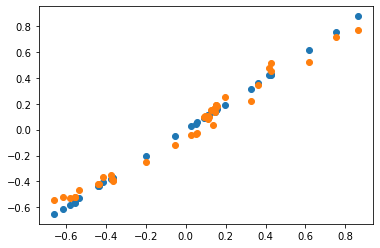

In [71]:
plt.scatter(qm_result,best_result)
plt.scatter(qm_result,pos_result)

In [88]:
lit_result=np.load("/media/linuxdata/sydong/software/EquivariantMultipoleGNN/temp_result.npy")

In [94]:
C22H20N4O5=pubchem_atoms_search(cid=101553505)
best_result=best_calc.calc(atoms=C22H20N4O5,total_charge=0)
pos_result=pos_calc(C22H20N4O5)
lit_result=np.load("/media/linuxdata/sydong/software/EquivariantMultipoleGNN/temp_result.npy")

/home/sydong/program/anaconda3/envs/cvx/lib/python3.9/site-packages/ase/data/pubchem.py:79: UserWarning: The structure "101553505" has more than one conformer in PubChem. By default, the first conformer is returned, please ensure you are using the structure you intend to or use the `ase.data.pubchem.pubchem_conformer_search` function
  warnings.warn('The structure "{}" has more than one '


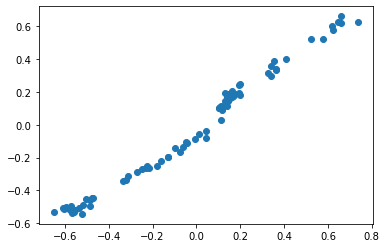

In [96]:
plt.scatter(lit_result,pos_result)

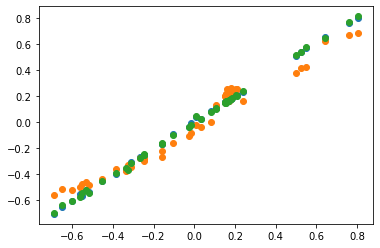

In [90]:
plt.scatter(qm_result,best_result)
plt.scatter(qm_result,pos_result)
plt.scatter(qm_result,lit_result)

# Fukui Function

In [34]:
from ase.data.pubchem import pubchem_atoms_search, pubchem_atoms_conformer_search
from ase.build import molecule
from ase.visualize.plot import plot_atoms

In [35]:
carbon_monoxide=molecule("CO")
carbon_dioxide=molecule("CO2")
formaldehyde=molecule("H2CO")
acetone=pubchem_atoms_search(cid=180)
cyanide=pubchem_atoms_search(cid=5975)
cyanate=pubchem_atoms_search(cid= 105034)
fulminate=pubchem_atoms_search(cid=12360)
aniline=pubchem_atoms_search(cid=6115)
hydroxylamine=pubchem_atoms_search(cid=787)
Hypofluorous_acid=pubchem_atoms_search(cid=123334)
Nitroxyl=pubchem_atoms_search(cid=945)
Nitrosobenzene=pubchem_atoms_search(cid=11473)

/home/sydong/program/anaconda3/envs/cvx/lib/python3.9/site-packages/ase/data/pubchem.py:79: UserWarning: The structure "11473" has more than one conformer in PubChem. By default, the first conformer is returned, please ensure you are using the structure you intend to or use the `ase.data.pubchem.pubchem_conformer_search` function
  warnings.warn('The structure "{}" has more than one '


In [43]:
molnupiravir=pubchem_atoms_search(cid=145996610)

In [333]:
fukui_result=[]
for i in np.linspace(-1,1,20):
    fukui_result.append(net.calc(carbon_monoxide,i))
fukui_result=np.array(fukui_result).squeeze()

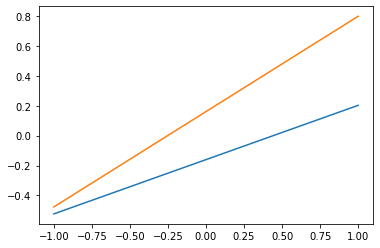

In [336]:
plt.plot(np.linspace(-1,1,20),fukui_result)

In [351]:
def fukui_function(atoms):
    fukui_result=[]
    for i in np.linspace(-1,1,20):
        fukui_result.append(net.calc(atoms,i))
    fukui_result=np.array(fukui_result).squeeze()
    plt.plot(np.linspace(-1,1,20),fukui_result,label=atoms.get_chemical_symbols())
    plt.legend()
    pos=net.calc(atoms,1)
    neu=net.calc(atoms,0)
    neg=net.calc(atoms,-1)
    print(atoms.get_chemical_symbols())
    print(pos-neu)
    print(neu-neg)

['O', 'C']
[[[0.36279285]
  [0.63720715]]]
[[[0.36279947]
  [0.6372006 ]]]


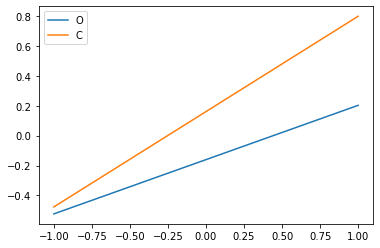

In [352]:
fukui_function(carbon_monoxide)

['C', 'O', 'O']
[[[0.37517458]
  [0.31241268]
  [0.31241268]]]
[[[0.37516946]
  [0.31241527]
  [0.31241527]]]


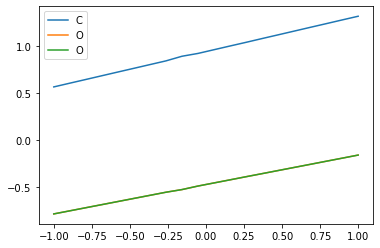

In [353]:
fukui_function(carbon_dioxide)

['O', 'C', 'H', 'H']
[[[0.23565152]
  [0.37539276]
  [0.19447786]
  [0.19447786]]]
[[[0.23569396]
  [0.37536234]
  [0.19447187]
  [0.19447187]]]


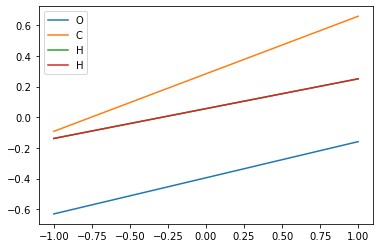

In [354]:
fukui_function(formaldehyde)

['O', 'C', 'C', 'C', 'H', 'H', 'H', 'H', 'H', 'H']
[[[0.11515507]
  [0.12798798]
  [0.12404507]
  [0.12404639]
  [0.08301899]
  [0.08300462]
  [0.0883619 ]
  [0.08836003]
  [0.08301495]
  [0.0830048 ]]]
[[[0.11508721]
  [0.12807745]
  [0.12396008]
  [0.12396139]
  [0.08304332]
  [0.08302893]
  [0.08838753]
  [0.08838566]
  [0.08303928]
  [0.08302912]]]


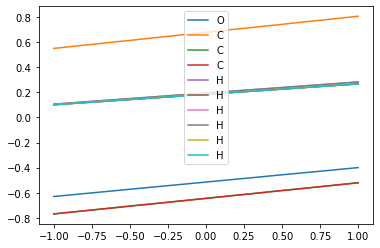

In [360]:
fukui_function(acetone)

['O', 'N', 'C']
[[[0.37531036]
  [0.3470775 ]
  [0.2776121 ]]]
[[[0.37547716]
  [0.3472345 ]
  [0.27728832]]]


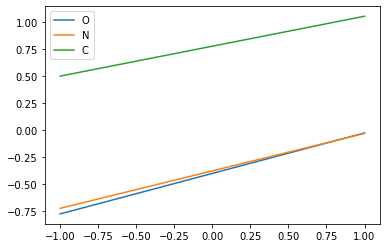

In [364]:
fukui_function(cyanate)

<AxesSubplot:>

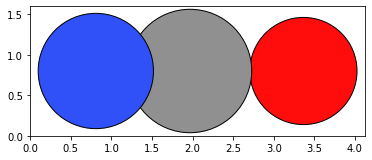

In [370]:
plot_atoms(cyanate)

['N', 'C']
[[[0.5418849 ]
  [0.45811498]]]
[[[0.541615]
  [0.458385]]]


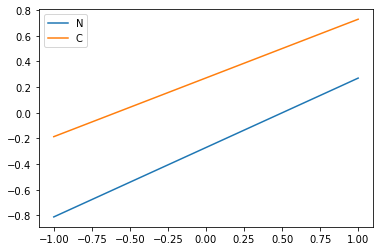

In [372]:
fukui_function(cyanide)

<AxesSubplot:>

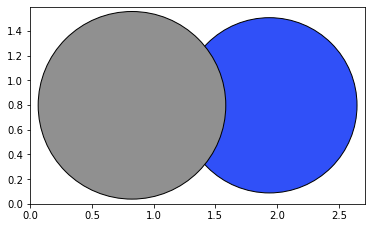

In [373]:
plot_atoms(cyanide)

['O', 'N', 'C']
[[[0.32524142]
  [0.31451666]
  [0.36024192]]]
[[[0.3252974 ]
  [0.31445652]
  [0.36024606]]]


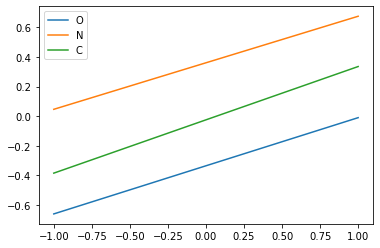

In [374]:
fukui_function(fulminate)

<AxesSubplot:>

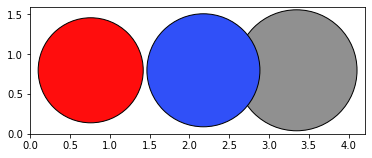

In [375]:
plot_atoms(fulminate)

['O', 'N', 'H', 'H', 'H']
[[[0.23679367]
  [0.22838718]
  [0.17139724]
  [0.17140171]
  [0.19202024]]]
[[[0.23695645]
  [0.22860289]
  [0.17128038]
  [0.17128491]
  [0.1918754 ]]]


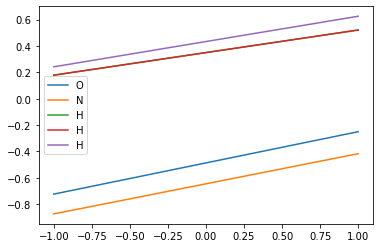

In [376]:
fukui_function(hydroxylamine)

['O', 'N', 'H']
[[[0.35993177]
  [0.44987598]
  [0.1901922 ]]]
[[[0.35993686]
  [0.4498812 ]
  [0.19018193]]]


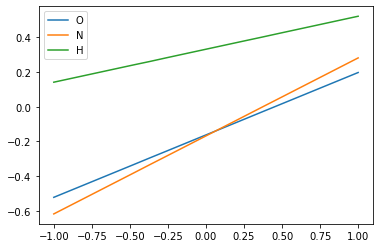

In [377]:
fukui_function(Nitroxyl)

['F', 'O', 'H']
[[[0.21610332]
  [0.43283406]
  [0.3510626 ]]]
[[[0.2161065 ]
  [0.43284452]
  [0.35104898]]]


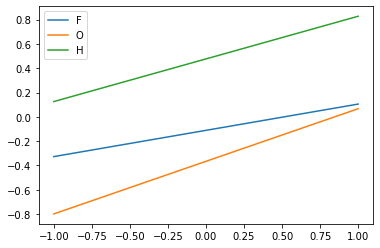

In [378]:
fukui_function(Hypofluorous_acid)

['O', 'N', 'C', 'C', 'C', 'C', 'C', 'C', 'H', 'H', 'H', 'H', 'H']
[[[0.08774158]
  [0.09514276]
  [0.08148971]
  [0.09712809]
  [0.09713867]
  [0.09280882]
  [0.09281481]
  [0.10116784]
  [0.04894122]
  [0.04893921]
  [0.05216238]
  [0.05217461]
  [0.05235057]]]
[[[0.08785145]
  [0.09514209]
  [0.08136234]
  [0.09725678]
  [0.09726733]
  [0.09287932]
  [0.09288536]
  [0.1012539 ]
  [0.04884216]
  [0.0488401 ]
  [0.05207272]
  [0.05208495]
  [0.0522617 ]]]


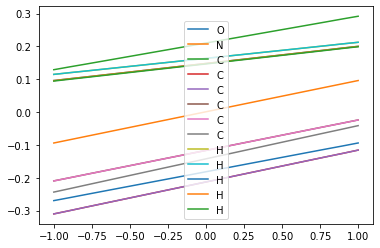

In [380]:
fukui_function(Nitrosobenzene)

# size dependency water cluster

In [417]:
import time
calc_time=[]
calc_result=[]
for i in [j for j in range(2,31)]+[32,40,50,64]:
    fname="./cluster/water_{}.xyz".format(i)
    cluster=read(fname)
    begin=time.time()
    charge=net.calc(cluster,0)
    end=time.time()
    calc_result.append(charge)
    calc_time.append(end-begin)

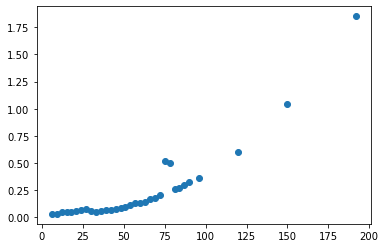

In [418]:
plt.scatter([j*3 for j in range(2,31)]+[32*3,40*3,50*3,64*3],calc_time)

In [430]:
qm_result=[]
for i in range(2,30):
    charge=np.load("./cluster/water_{}.npy".format(i))
    qm_result.append(charge)

(1, 6, 1)

In [436]:
maes=[]
for i in range(28):
    mae=np.abs(qm_result[i].squeeze()-calc_result[i].squeeze()).mean()
    maes.append(mae)

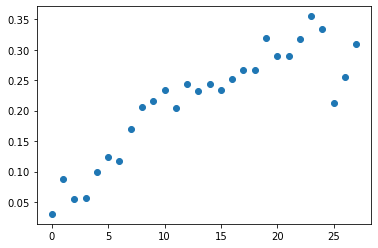

In [437]:
plt.scatter(range(28),maes)

# Predict charge transfer

In [21]:
from ase.io  import read
from hogwild.interface import ChargeNet
net=ChargeNet()
qm_result=np.load("/home/sydong/data/result.npy")
atoms=read("/home/sydong/data/opt.xyz")
charge=net.calc(atoms,-1)

model at /home/sydong/work/deepchem/cvxcharge/hogwild/final_cpu_model.pt


In [48]:
neutral_result=np.load("/home/sydong/data/neutral.npy")
neutral=read("/home/sydong/data/neutral.xyz")
lit_neu=np.load("/home/sydong/data/lit_neu.npy")
neutral_predict=net.calc(neutral,0)

In [51]:
a=np.max(np.abs(neutral_result-neutral_predict.squeeze(0)))
b=np.max(np.abs(neutral_result-lit_neu))

In [84]:
np.sum(charge)

-1.0

In [60]:
from ase.visualize import view

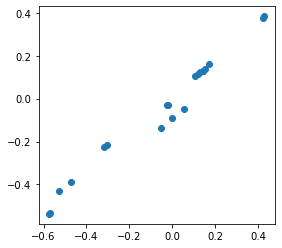

In [82]:
plt.scatter(qm_result,charge[0])
ax=plt.gca()
ax.set_aspect("equal")


In [69]:
atoms.set_initial_charges(qm_result.squeeze())
neutral.set_initial_charges(neutral_result.squeeze())

In [80]:
ind=14
print(qm_result[ind],
charge[0][ind],
     neutral_result[ind],
     neutral_predict[0][ind])

[-0.47350889] [-0.38913164] [-0.34555342] [-0.34465963]


In [68]:
view(atoms)

<Popen: returncode: None args: ['/home/sydong/program/anaconda3/envs/cvx/bin...>

In [70]:
view(neutral)

<Popen: returncode: None args: ['/home/sydong/program/anaconda3/envs/cvx/bin...>